<b><font size=5>貪欲法＆動的計画法による<br>
複数ナップザック問題の近似解推定</font></b>

In [1]:
# 必要なモジュールのインポート
import time
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ortoolpy import knapsack

### ○データの準備

<b>データの形式は、以下のようになっている必要がある。</b>
<br>
<b>※ただし、price_iは、クライアントiの取引価格、rating_iは、クライアントiの指定視聴率である。</b>

||||||||
|:--:|:--:|:--:|:--:|:--:|:--:|:--|
|id|price_0|...|price_n|rating_0|...|rating_n|
|418|230||450|1.3||3.2|
|1864|420||520|3.4||2.9
|432|780||390|9.0||4.3|
|12|630||450|8.9||7.9|

In [2]:
# サンプルデータの読み込み
df_sample = pd.read_csv('sample_10*5000.csv', sep='\t')
df_sample.head(3)

,id,price_0,price_1,price_2,price_3,price_4,price_5,price_6,price_7,price_8,...,rating_0,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6,rating_7,rating_8,rating_9
0,1,380,385,389,375,387,385,382,378,385,...,4.1,3.3,4.0,3.5,3.8,4.5,4.1,3.8,3.8,3.8
1,2,943,947,961,960,960,947,950,940,944,...,10.1,8.9,9.3,10.3,9.4,9.5,9.9,9.4,8.4,9.1
2,3,980,980,987,982,974,982,981,982,975,...,10.4,8.7,10.3,9.8,9.3,9.0,9.8,9.8,9.8,9.8


In [3]:
# clientの数。 
# １行（id）分引いて2で割れば、クライアントの数になる。
client_num = int((len(df_sample.columns)-1)/2)
print('クライアントの数:', client_num)

クライアントの数: 10


In [4]:
# 初めにクライアントが持っていた枠をランダムに決める（別のデータに対応できるかを見るため。）
# そのため、df_inputをモデルにいれる。
df_input = df_sample.sample(frac=1).reset_index(drop=True)
df_input.head(3) # ランダムになっていることの確認。

,id,price_0,price_1,price_2,price_3,price_4,price_5,price_6,price_7,price_8,...,rating_0,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6,rating_7,rating_8,rating_9
0,250,461,452,450,441,435,434,440,440,432,...,4.6,4.8,4.8,5.2,5.6,4.7,3.8,4.7,4.4,3.5
1,2373,994,991,983,991,991,991,995,990,990,...,10.0,9.2,9.2,9.9,10.0,10.0,10.4,10.7,10.2,9.8
2,2454,1011,1007,1014,1007,1007,1003,1012,1012,1014,...,10.1,10.1,11.1,10.4,10.0,10.0,9.9,10.5,9.5,9.5


In [5]:
# クライアト0, 1, 2の元々持っていた枠をランダムに決める。
length = len(df_input) # データフレームの長さ
bps = [0 for i in range(client_num+1)] # Break Points
bp = 0
original_prices = [0 for i in range(client_num)] # 元々持っていた枠の価格和。
original_points = [0 for i in range(client_num)] # 元々持っていた枠の視聴率和。
original_idses = [[] for i in range(client_num)] # 元々持っていた枠のid。

for i in range(client_num):
    bp += length//client_num
    bps[i+1] = bp
    df_original = df_input[bps[i]:bps[i+1]] # 各クライアントが元々持っていた枠のデータフレーム 
    original_prices[i] = sum(df_original['price_' + str(i)]) # 元々持っていた価格の和。
    original_points[i] = sum(df_original['rating_' + str(i)]) # 元々持っていた視聴率の和。
    original_idses[i] = df_original['id'].tolist()

In [6]:
print(original_prices) # 元々持っていた枠の価格和。
print(original_points) # 元々持っていた枠の視聴率和。

[426624, 434187, 432669, 437889, 423483, 421278, 417917, 420002, 418367, 401459]
[4270.899999999997, 4324.8, 4313.100000000002, 4389.800000000001, 4231.499999999998, 4201.9000000000015, 4179.700000000001, 4199.400000000002, 4183.699999999999, 4019.1000000000004]


In [7]:
# value=「視聴率/号数（価格）」を求める。(これを比較して、貪欲に取り出す。)
for i in range(client_num):
    df_input['value_'+str(i)] = df_input['rating_'+str(i)]/df_input['price_'+str(i)]
    
df_input.head(3) # valueのできていることの確認。

,id,price_0,price_1,price_2,price_3,price_4,price_5,price_6,price_7,price_8,...,value_0,value_1,value_2,value_3,value_4,value_5,value_6,value_7,value_8,value_9
0,250,461,452,450,441,435,434,440,440,432,...,0.009978,0.010619,0.010667,0.011791,0.012874,0.010829,0.008636,0.010682,0.010185,0.008083
1,2373,994,991,983,991,991,991,995,990,990,...,0.010060,0.009284,0.009359,0.009990,0.010091,0.010091,0.010452,0.010808,0.010303,0.009959
2,2454,1011,1007,1014,1007,1007,1003,1012,1012,1014,...,0.009990,0.010030,0.010947,0.010328,0.009930,0.009970,0.009783,0.010375,0.009369,0.009415


***
***

### ○ここから関数定義（アルゴリズムの中身）

In [8]:
# 超貪欲法
def Greedy_Algorithm(df, require_points, got_idses, num, mutation=100):
    require_ratings = list(require_points) # 参照してしまい、値が変わってしまうのを防ぐため。
    achieved_num=0 # 目的を達成した（元々の視聴率和を超えた）クライアントの数。    
    value_col_names = ['value_'+str(i) for i in range(num)] # valueのカラム名（ここから目的を達成したクライアントを取り除いていく。）
    
    while achieved_num < num:
        df['Max_value'] = df.loc[:, value_col_names].max(axis=1) # (残っている)クライアントの価値の中で最も高い値。
        df['Max_value_client'] = df.loc[:, value_col_names+['Max_value']].apply(lambda x : list(x[x==x['Max_value']].index)[:-1],axis=1)# 最も高い値をつけているクライアント（複数）
        df['Max_value_client'] = df['Max_value_client'].apply(lambda x: random.choice(x).replace('value_', '')) # その中からクライアントを一つ選ぶ。
        df = df.sort_values(by='Max_value', ascending=False).reset_index(drop=True) # その価値でソートする。
        
        for i in range(len(df)):
            if random.randrange(int(mutation)) != 1:
                name = int(df.at[0, 'Max_value_client']) # 最も高い値をつけているクライアントの名前。（というか番号。）
            else:
                name = int(random.choice(value_col_names).replace('value_', ''))
                mutation *= 1.2 # 突然変異が起きる確率を下げていく。
                # mutation += 10
            require_ratings[name] -= df.at[0, 'rating_'+str(name)] # 必要な視聴率和からその枠の視聴率を引く。
            got_idses[name] += [df.iat[0, 0]] # 獲得した枠のidを記録する。([df.at[0, 'id']])
            df = df[1:].reset_index(drop=True) # dfを下っていく。
            if min(require_ratings) < 0: # どこかのクライアントが、目的を達成したら、一回終わり。
                break

        # もしも目的を達成できなかったクライアントがいる場合、このachieved_clientが違うクライアント（すでに取り除かれたクライアント）になってしまう。
        achieved_client = require_ratings.index(min(require_ratings)) # 目的を達成したクライアント名。（番号）
        require_ratings[achieved_client] = 0 # 目的を達成したら、0にする。（今後のため。）
        try:
            value_col_names.remove('value_'+str(achieved_client)) # 目的を達成したクライアントは、除く。
        except ValueError: # list.remove(x): x not in list ってやつ。
            return got_idses
        achieved_num += 1 # チェックポイント＝目的を達成したクライアントの数。    
            
    return got_idses # ぞれぞれのクライアントが獲得したidを返す。

In [4]:
# 凸最適化
def Knapsack_Convex_Optimization(size, weight, capacity):
    x = cvxpy.Variable(len(size), boolean=True)
    objective = cvxpy.Maximize(weight * x)
    constraints = [capacity >= size * x]
    prob = cvxpy.Problem(objective, constraints)
    prob.solve(solver=cvxpy.ECOS_BB)
    result = [round(ix, 0) for ix in x.value]
    result = set([i if result[i]==1 else 'a' for i in range(len(result))])
    result.remove('a')
    
    return list(result)

In [9]:
# 複数ナップサックランダムチョイス
# 動的計画法（凸最適化）
def Dynamic_Programming(df, initial_prices, got_prices, rate, num):
    got_idses = [[] for i in range(num)] # 最終的に手にいれることのできたidのリスト
    capacities = list(np.array(initial_prices) * rate - np.array(got_prices))
    while len(df)>0:
        knapsack_indexes = [[] for i in range(num)] # ナップサックに入れたindexのリスト。
        add_indexes = [[] for i in range(num)] # 結果的に手にいれることのできたindexのリスト。
        
        for i in range(num):
            size = list(np.array(df['price_' + str(i)]))
            weight = list(np.array(df['rating_' + str(i)]))
            capacity = capacities[i]
            knapsack_indexes[i] = knapsack(size, weight, capacity)[1]
            # knapsack_indexes[i] = Knapsack_Convex_Optimization(size, weight, capacity)
            
        chosen_index_dict = dict() # 一回のナップサックで選ばれたindexを格納する。
        for index in range(len(df)): 
            values = [] # そのindexを選択したクライアントの名前（番号）を格納する。
            for i in range(num):
                if index in knapsack_indexes[i]:
                    values.append(i) # 選択していたら加える。
            if values: # 選択したクライアントがいれば
                value = random.choice(values) # その中から一人（ランダムに）選んで
                chosen_index_dict[index] = value # indexとともに格納する。
                
        if len(chosen_index_dict)==0: # もしどのクライアントもidを選ばなかったら
            return got_idses
                
        for i in range(client_num):
            add_indexes[i] = [index for index, client in chosen_index_dict.items() if client == i] # クライアントごとに、獲得した枠のindex
            got_idses[i] += df.query('index in ' + str(add_indexes[i]))['id'].values.tolist()
            capacities[i] -= sum(df.query('index in ' + str(add_indexes[i]))['price_' + str(i)]) # キャパシティから引いていく。

        extraction_ids = Flatten_dual(add_indexes) # 今回獲得されたidの集合
        df = df.query('index not in ' + str(extraction_ids)).reset_index(drop=True)
    
    return got_idses

In [10]:
# 手に入れた枠のidのリストを渡せば、手に入れた枠の価格と視聴率和を返す関数。
# Check Prices and Points
def Check_pp(df, got_idses, num):
    got_prices = [0 for i in range(num)]
    got_points = [0 for i in range(num)]
    for i in range(num):
        df_got = df[df['id'].apply(lambda x:x in got_idses[i])]
        got_prices[i] = sum(df_got['price_' + str(i)])
        got_points[i] = sum(df_got['rating_' + str(i)])
    return got_prices, got_points    


# 手に入れた枠のidのリストを渡せば、残ったデータフレームを返す関数。
def Check_remainingdf(df, got_idses):
    all_got_ids = Flatten_dual(got_idses) # クライアントが獲得したアカウント全てを足し合わせたもの。
    df_remain = df[df['id'].apply(lambda x:x not in all_got_ids)].reset_index(drop=True)
    return df_remain

In [11]:
# 分配の公平性を調べる。
def Judge_fairness(before_points, after_points):
    x_client = (np.array(after_points) / np.array(before_points))
    mean_array = np.full(len(x_client), x_client.mean())
    return sum(((x_client - mean_array)**2/len(x_client))**(1/2)/x_client.mean())

# 分配の効率を調べる。(増えた視聴率/枠数)
def Judge_efficiency(before_points, after_points, got_idses):
    ids_num = len(Flatten_dual(got_idses))
    profit = sum(np.array(after_points) - np.array(before_points))
    return profit/ids_num

# 分配の公平性を調べる。（枠の数） 単純に分散を出しているだけ。
def Judge_Number_fairness(before_ids, after_ids):
    before_id_num = [len(before_ids[i]) for i in range(len(before_ids))]
    after_id_num = [len(after_ids[i]) for i in range(len(after_ids))]
    return Judge_fairness(before_id_num, after_id_num)

In [12]:
# 2重のリストをフラットにする関数(重複は残る！)
def Flatten_dual(nested_list):
    return [e for inner_list in nested_list for e in inner_list]

### ○実際にアルゴリズムを動かす。

In [13]:
print('初めの枠数:', len(df_input))
start = time.time() # プログラム開始時間
failing_clients = [] # エラー処理用。目的達成できなかったクライアントの番号を格納する。
clients = [i for i in range(client_num)] # エラー処理用。クライアントの番号を入れておく。
error = 0
GA_judge = []
while error==0: # 特に意味はない。breakまでずっと回り続ける。
    GA_results = dict() # 公平性/効率性をkey, 手に入れたidをvalueとしたディクショナリ
    for i in range(50): # 貪欲法のループ
        obtained_idses = [[] for i in range(client_num)] # 初期化する。
        GA_after_idses = Greedy_Algorithm(df_input, original_points, obtained_idses, client_num, mutation=100)
        GA_after_prices, GA_after_points = Check_pp(df_input, GA_after_idses, client_num)
        # amount_fairness = Judge_fairness(original_points, GA_after_points)
        # GA_results[amount_fairness] = GA_after_idses
        # efficiency = sum(GA_after_points)
        # GA_results[efficiency] = GA_after_idses
        number_fairness = Judge_Number_fairness(original_idses, GA_after_idses)
        GA_results[number_fairness] = GA_after_idses
        GA_judge.append(number_fairness)
        print(str(i+1)+'ループ目: 経過時間', round(time.time()-start,5), '[sec]')

    GA_after_idses = GA_results[max(GA_results.keys())] # Greedy Algorithm で各クライアントが手に入れたidのリスト。
    df_GAremain = Check_remainingdf(df_input, GA_after_idses) # 残っているデータフレーム  
    GA_after_prices, GA_after_points = Check_pp(df_input, GA_after_idses, client_num)

#****************エラー処理****************これで、目的を達成できなかったクライアントがいても、そのクライアントを除いて回り続ける。
    if len(set([GA_after_points[i] > original_points[i] for i in range(client_num)])) > 1: #もしも目的を達成できなかったクライアントがいれば
        print('Error')
        failing_client = [i for i, x in enumerate([GA_after_points[i] > original_points[i] for i in range(client_num)]) if x == False]
        original_points = [original_points[i] if i not in failing_client else 'remove' for i in range(client_num)] # 
        original_points.remove('remove')
        new_columns = list(set(df_input.columns) - set(Flatten_dual([['price_'+str(failing_client[i]), 'rating_'+str(failing_client[i]), 'value_'+str(failing_client[i])] for i in range(len(failing_client))])))
        df_input = df_input.loc[:, new_columns]
        client_num -= len(failing_client)
        failing_clients += [clients[failing_client[i]] for i in range(len(failing_client))] #目的を達成できなかったクライアントの、名前（番号が記録されている。）
        clients = [clients[i] if i not in failing_client else 'remove' for i in range(clients)] # 
        clients.remove('remove')
    else:
        break
#****************エラー処理****************つまり、元々のクライアントは

GA_end = time.time()
print('*'*17, '超貪欲法終了', '*'*17)
print('プログラム処理経過時間', round(GA_end-start,5), '[sec]')
print('残り枠数:', len(df_GAremain))

DP_judge = []
DP_results = dict() 
rate = 1.05
for i in range(50): # 動的計画法のループ
    DP_after_idses= Dynamic_Programming(df_GAremain, original_prices, GA_after_prices, rate, client_num)
    DP_after_prices, DP_after_points = Check_pp(df_GAremain, DP_after_idses, client_num)
    # amount_fairness = Judge_fairness(GA_after_points, DP_after_points)
    # DP_results[fairness] = DP_after_idses
    efficiency = sum(DP_after_points)
    DP_results[efficiency] = DP_after_idses
    # number_fairness = Judge_Number_fairness(original_idses, DP_afteridses)
    # DP_results[number_fairness] = DP_after_idses
    DP_judge.append(efficiency)
    print(str(i+1)+'ループ目: 経過時間', round(time.time()-start,5), '[sec]')
    
DP_after_idses = DP_results[max(DP_results.keys())]
df_DPremain = Check_remainingdf(df_GAremain, DP_after_idses) # 残っているデータフレーム  
DP_after_prices, DP_after_points = Check_pp(df_GAremain, DP_after_idses, client_num)

DP_end = time.time()
print('*'*16, '動的計画法終了', '*'*16)
print('プログラム処理経過時間', round(DP_end-start,5), '[sec]')
print('残り枠数:', len(df_DPremain))

if len(df_DPremain)!=0:
    print('全ての枠が交換されませんでした。価格の上限幅を大きくしてください！')

achieved_total_prices = list(np.array(GA_after_prices) + np.array(DP_after_prices))
achieved_total_points = list(np.array(GA_after_points) + np.array(DP_after_points))
achieved_total_idses  = list(np.array(GA_after_idses)  + np.array(DP_after_idses))

# これにより、目的を達成できなかったクライアントは、交換結果が初めと変わらない
total_prices = [original_prices[i] if i in failing_clients else achieved_total_prices[i] for i in range(len(clients))]
total_points = [original_points[i] if i in failing_clients else achieved_total_points[i] for i in range(len(clients))]
total_idses  = [original_idses[i] if i in failing_clients else achieved_total_idses[i] for i in range(len(clients))]

profit = list(np.array(total_points) - np.array(original_points))
price_difference = list(np.array(total_prices) - np.array(original_prices))

np.set_printoptions(precision=3)
print('*' * 48)
print('利益　:', profit)
print('価格差:', price_difference)

初めの枠数: 5000
1ループ目: 経過時間 11.36784 [sec]
2ループ目: 経過時間 22.1403 [sec]
3ループ目: 経過時間 32.864 [sec]
4ループ目: 経過時間 43.52917 [sec]
5ループ目: 経過時間 54.28586 [sec]
6ループ目: 経過時間 65.11714 [sec]
7ループ目: 経過時間 75.88794 [sec]
8ループ目: 経過時間 86.65201 [sec]
9ループ目: 経過時間 97.42488 [sec]
10ループ目: 経過時間 108.16313 [sec]
11ループ目: 経過時間 118.90845 [sec]
12ループ目: 経過時間 129.55289 [sec]
13ループ目: 経過時間 140.44922 [sec]
14ループ目: 経過時間 151.19307 [sec]
15ループ目: 経過時間 161.97501 [sec]
16ループ目: 経過時間 172.76326 [sec]
17ループ目: 経過時間 183.51569 [sec]
18ループ目: 経過時間 194.31495 [sec]
19ループ目: 経過時間 205.14545 [sec]
20ループ目: 経過時間 215.88595 [sec]
21ループ目: 経過時間 226.64377 [sec]
22ループ目: 経過時間 237.45029 [sec]
23ループ目: 経過時間 248.17497 [sec]
24ループ目: 経過時間 259.00592 [sec]
25ループ目: 経過時間 269.74506 [sec]
26ループ目: 経過時間 280.47177 [sec]
27ループ目: 経過時間 291.25766 [sec]
28ループ目: 経過時間 302.09433 [sec]
29ループ目: 経過時間 313.60675 [sec]
30ループ目: 経過時間 324.91587 [sec]
31ループ目: 経過時間 335.75582 [sec]
32ループ目: 経過時間 346.46919 [sec]
33ループ目: 経過時間 357.20346 [sec]
34ループ目: 経過時間 367.98189 [sec]
35ループ目: 経過時間 378.80878 

### ○収束のスピード感

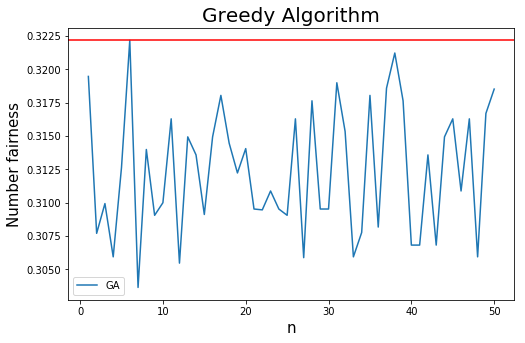

In [14]:
plt.figure(figsize=(8,5))
plt.plot([i+1 for i in range(len(GA_judge))],GA_judge, label='GA')
plt.axhline(y=max(GA_judge), color='r', linestyle='-')
plt.title('Greedy Algorithm', size=20)
plt.xlabel('n', size=15)
plt.ylabel('Number fairness', size=15)
plt.legend()
plt.show()

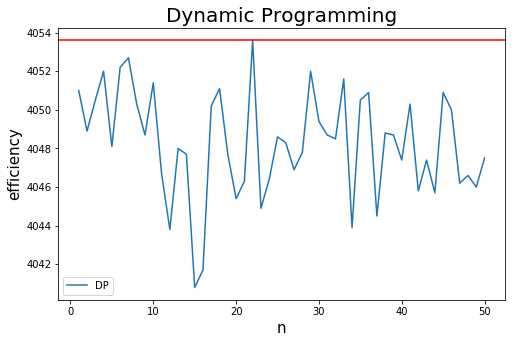

In [15]:
plt.figure(figsize=(8,5))
plt.plot([i+1 for i in range(len(DP_judge))],DP_judge, label='DP')
plt.axhline(y=max(DP_judge), color='r', linestyle='-')
plt.title('Dynamic Programming', size=20)
plt.xlabel('n', size=15)
plt.ylabel('efficiency', size=15)
plt.legend()
plt.show()

### ○エラー処理に関して
<b>もしも最後に枠が余って入れば（全てのクライアントが価格のキャパシティを超えてしまった）、「価格のキャパシティを大きくしてください」的なメッセージを出せば良き。</b>

***

## ●プロトタイプのモデルは完成

<b>ここからやらなければならないこと。
    1. 実際のデータで動かしてみる。
    2. プログラムの見直し
    3. 視聴率予測は、結局のところ予測である。
    →誤差が生じる可能性があり、その誤差は予測視聴率が高いところほど大きい。それを踏まえて、何か上手い方法はないか？（例えば、視聴率が高いと予測された枠を多く取得したクライアントはリスクがデカい。）